# Chapter6 再帰型ニューラルネットワーク（テキストデータの分類）　～感情分析プログラムを作る～
## 2. 感情分析の基本

## 2.2. 前準備（パッケージのインポート）

In [ ]:
# 必要なパッケージのインストール
import numpy as np
import spacy
import matplotlib.pyplot as plt
import torch
from torchtext import data
from torchtext import datasets
from torch import nn
import torch.nn.functional as F
from torch import optim

## 2.3. 訓練データとテストデータの用意

In [ ]:
# Text, Label Fieldの定義
all_texts = data.Field(tokenize = 'spacy')  # テキストデータのField
all_labels = data.LabelField(dtype = torch.float)  # ラベルデータのField

In [ ]:
# データの取得
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

print("train_data size: {}".format(len(train_dataset)))  # 訓練データのサイズ
print("test_data size: {}".format(len(test_dataset))) # テストデータのサイズ

aclImdb_v1.tar.gz:   0%|          | 197k/84.1M [00:00<00:49, 1.71MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 61.9MB/s]


train_data size: 25000
test_data size: 25000


In [ ]:
# 訓練データの中身の確認
print(vars(train_dataset.examples[0]))

{'text': ['I', 'heard', 'tell', 'that', 'Madonna', 'was', 'briefly', 'considered', 'for', 'the', 'Catherine', 'Tremell', 'role', '.', 'Compared', 'to', 'Sharon', 'Stone', ',', 'Madonna', 'is', 'too', 'coarse', 'and', 'BAUERISCH', '.', 'She', "'s", 'not', 'even', 'close', '.', '<', 'br', '/><br', '/>EVIL', 'INCARNATE', ':', 'Sharon', 'Stone', 'is', 'a', 'bit', 'long', 'in', 'the', 'tooth', ',', 'the', 'ameliorative', 'effects', 'of', 'modern', 'chemistry', 'and', 'surgery', 'notwithstanding', '.', 'However', ',', 'she', 'artfully', 'treats', 'us', 'to', 'a', 'frightening', 'personification', 'of', 'evil', 'beyond', 'redemption', '.', 'In', 'the', 'obligatory', 'sex', 'scene', ',', 'she', 'projects', 'pure', ',', 'crystalline', 'lust', '.', 'Especially', 'her', 'hooded', ',', 'luminous', 'eyes', 'and', 'a', 'face', 'flat', 'with', 'pleasure', '.', 'Thanks', 'to', 'brilliant', 'use', 'of', 'lighting', 'and', 'other', 'stage', 'techniques', ',', 'the', 'harsh', 'lines', 'of', 'age', 'are',

In [ ]:
# 単語帳（Vocabulary）の作成
max_vocab_size = 25_000

all_texts.build_vocab(train_dataset, max_size = max_vocab_size)
all_labels.build_vocab(train_dataset)

print("Unique tokens in all_texts vocabulary: {}".format(len(all_texts.vocab)))
print("Unique tokens in all_labels vocabulary: {}".format(len(all_labels.vocab)))

Unique tokens in all_texts vocabulary: 25002
Unique tokens in all_labels vocabulary: 2


In [ ]:
# 上位20位の単語
print(all_texts.vocab.freqs.most_common(20))

[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546), ('it', 76545), ('that', 70355), ('"', 63329), ("'s", 61928), ('this', 60483), ('-', 52863), ('/><br', 50935), ('was', 50013), ('as', 43508), ('with', 42807)]


In [ ]:
# テキストは数値化されているがテキストに変換することもできる
print(all_texts.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
# labelの0と1がネガティブとポジティブどちらかを確認できる
print(all_labels.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f8ef83529d8>, {'neg': 0, 'pos': 1})


In [ ]:
# ミニバッチの作成
batch_size = 64
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# デバイスの確認
print("Device: {}".format(device))

train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),  # データセット
    batch_size = batch_size,  # バッチサイズ
    device = device)  # CPUかGPUかを指定

for batch in train_batch:
  print("text size: {}".format(batch.text.size()))  # テキストデータのサイズ
  print("label size: {}".format(batch.label.size()))  # ラベルデータのサイズ
  break

Device: cuda
text size: torch.Size([1134, 64])
label size: torch.Size([64])


## 2.4. ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, D_embedding, H, D_out):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(D_in, D_embedding)  # 埋め込み層
        self.lstm = nn.LSTM(D_embedding, H, num_layers=1)  # LSTM層
        self.linear = nn.Linear(H, D_out)  # 全結合層
        
    def forward(self, x):
        embedded = self.embedding(x)  #embedded = [sent len, batch size, emb dim], x = [sent len, batch size]
        output, (hidden, cell) = self.lstm(embedded)  #output = [sent len, batch size, hid dim]
        output = self.linear(output[-1, : , :]) # 最後のステップのみを入力
        return output

In [ ]:
# ニューラルネットワークのロード
D_in = len(all_texts.vocab)  # 入力層の次元
D_embedding = 100  # 埋め込み層の次元
H = 256  # 隠れ層の次元
D_out = 1  # 出力層の次元

net = Net(D_in, D_embedding, H, D_out).to(device)  # ニューラルネットワークの読み込み
print(net)

Net(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


## 2.5. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.BCEWithLogitsLoss()  # ロジット付きバイナリ交差エントロピー損失

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 2.6. 学習

In [ ]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for batch in train_batch:
        # GPUにTensorを転送
        texts = batch.text  # レビューデータ
        labels = batch.label  # ラベルデータ
        

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(texts).squeeze(1)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
        # ミニバッチごとに正解したラベル数をカウントし、正解率を計算
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch)
    epoch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for batch in test_batch:
            # GPUにTensorを転送
            texts = batch.text  # レビューデータ
            labels = batch.label  # ラベルデータ
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(texts).squeeze(1)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
            # ミニバッチごとに正解したラベル数をカウント、正解率を計算
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch)
    epoch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)  # 学習損失
    train_accuracy_list.append(epoch_train_accuracy)  # 学習正答率
    test_loss_list.append(epoch_test_loss)  # テスト損失
    test_accuracy_list.append(epoch_test_accuracy)  # テスト正答率

---------------------------------------------
Epoch: 1/10
Train_Loss: 0.6941, Train_Accuracy: 0.5012
Test_Loss: 0.6870, Test_Accuracy: 0.6422
---------------------------------------------
Epoch: 2/10
Train_Loss: 0.6933, Train_Accuracy: 0.5027
Test_Loss: 0.6848, Test_Accuracy: 0.6441
---------------------------------------------
Epoch: 3/10
Train_Loss: 0.6929, Train_Accuracy: 0.5039
Test_Loss: 0.6833, Test_Accuracy: 0.4790
---------------------------------------------
Epoch: 4/10
Train_Loss: 0.6924, Train_Accuracy: 0.5023
Test_Loss: 0.6978, Test_Accuracy: 0.5522
---------------------------------------------
Epoch: 5/10
Train_Loss: 0.6913, Train_Accuracy: 0.5029
Test_Loss: 0.7462, Test_Accuracy: 0.5238
---------------------------------------------
Epoch: 6/10
Train_Loss: 0.6906, Train_Accuracy: 0.5011
Test_Loss: 0.7302, Test_Accuracy: 0.5576
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.6892, Train_Accuracy: 0.5029
Test_Loss: 0.7240, Test_Accuracy: 0.5679
------

## 2.7. 結果の可視化

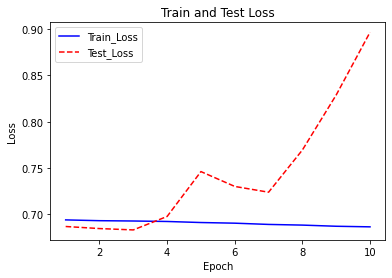

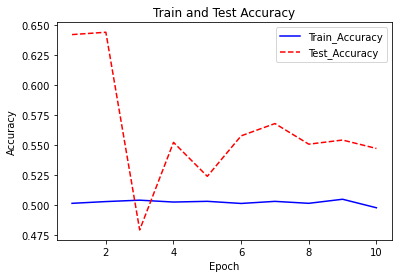

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()